<a href="https://colab.research.google.com/github/ralphcajipe/Deep-Learning-with-Python/blob/main/ham_or_spam_neural_network_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 Neural Network SMS Text Classifier
by Ralph Cajipe

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement, or a message sent by a company.

You should create a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or " spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the SMS Spam Collection dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

### 1.2 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
#!pip install tensorflow-datasets
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


### 1.3 The SMS Spam Collection dataset

In [ ]:
# Get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-10-19 03:59:24--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.2’

train-data.tsv.2    100%[===================>] 349.84K  --.-KB/s    in 0.03s   

2022-10-19 03:59:24 (10.4 MB/s) - ‘train-data.tsv.2’ saved [358233/358233]

--2022-10-19 03:59:24--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.2’

valid-data.tsv.2    100%[========

### 1.4 Creating the data

Create DataFrame for Training Data

In [ ]:
train_data = pd.read_csv(train_file_path, sep='\t', header=None, names=["type", "message"])
train_data.dropna()
train_data

,type,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [ ]:
train_data.shape

(4179, 2)

Create DataFrame for Test Data

In [ ]:
test_data = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "message"])
test_data.dropna()
test_data

,type,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


In [ ]:
test_data.shape

(1392, 2)

### 1.5 Preparing the data

Factorize the data identified as two distinct values

In [ ]:
train_data["type"] = pd.factorize(train_data["type"])[0]
test_data["type"] = pd.factorize(test_data["type"])[0]

In [ ]:
train_data.shape

(4179, 2)

In [ ]:
test_data.shape

(1392, 2)

Prepare train and test labels

Train Labels

In [ ]:
train_labels =  train_data["type"].values
train_data = tf.data.Dataset.from_tensor_slices(
    (train_data["message"].values, train_labels)
)
train_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Test Labels

In [ ]:
test_labels =  test_data["type"].values.astype(int)
test_data = tf.data.Dataset.from_tensor_slices(
    (test_data["message"].values, test_labels.astype(int))
)
test_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Get the number of examples in each of the two datasets

In [ ]:
num_train_examples = len(train_data)
num_test_examples = len(test_data)

print("Training Entries: {}, Test Entries: {}".format(num_train_examples, num_test_examples))

Training Entries: 4179, Test Entries: 1392


Reshape and Shuffle data

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create a Text Vectorization layer

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=1000, output_mode="int", output_sequence_length=1000)
text_vectorizer.adapt(train_data.map(lambda text, label: text))

Take a look at the first 50 words store in the vocabulary

In [ ]:
text_vectorizer.get_vocabulary()[:50]

['',
 '[UNK]',
 'to',
 'i',
 'you',
 'a',
 'the',
 'u',
 'and',
 'in',
 'is',
 'me',
 'my',
 'for',
 'your',
 'of',
 'it',
 'call',
 'have',
 'on',
 'that',
 'are',
 'now',
 'im',
 '2',
 'not',
 'but',
 'so',
 'at',
 'or',
 'do',
 'can',
 'with',
 'be',
 'will',
 'if',
 'get',
 'ur',
 'just',
 'we',
 'this',
 'no',
 'its',
 'up',
 'go',
 '4',
 'ok',
 'dont',
 'ltgt',
 'free']

### 1.6 Building your model

Model definition

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    text_vectorizer,
    layers.Embedding(len(text_vectorizer.get_vocabulary()), 64, mask_zero=True),
    layers.Bidirectional(keras.layers.LSTM(64,  return_sequences=True)),
    layers.Bidirectional(keras.layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1000, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Compiling the model

In [ ]:
model.compile(optimizer="rmsprop",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=["accuracy"])

Plot the model

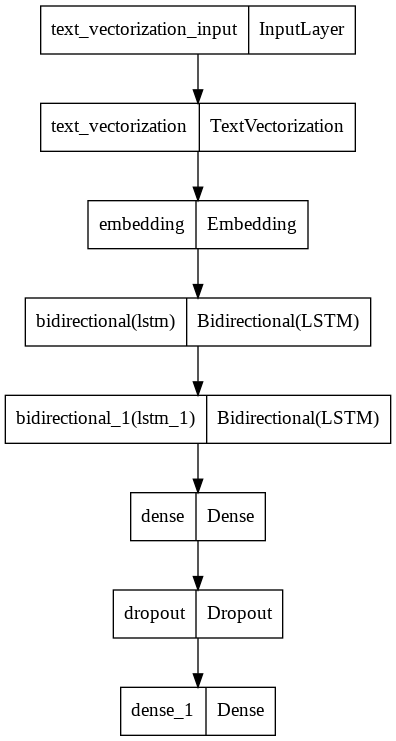

In [ ]:
keras.utils.plot_model(model, "sms_text_classifier.png")

### 1.7 Validating your approach

Setting aside a validation set

Training your model

In [ ]:
history = model.fit(train_data,
                    epochs=9,
                    validation_steps=30,
                    validation_data=test_data)

Epoch 1/9
131/131 [==============================] - 442s 3s/step - loss: 0.1940 - accuracy: 0.9419 - val_loss: 0.0556 - val_accuracy: 0.9823
Epoch 2/9
131/131 [==============================] - 435s 3s/step - loss: 0.0585 - accuracy: 0.9835 - val_loss: 0.0476 - val_accuracy: 0.9854
Epoch 3/9
131/131 [==============================] - 399s 3s/step - loss: 0.0435 - accuracy: 0.9856 - val_loss: 0.0483 - val_accuracy: 0.9854
Epoch 4/9
131/131 [==============================] - 402s 3s/step - loss: 0.0294 - accuracy: 0.9916 - val_loss: 0.0589 - val_accuracy: 0.9875
Epoch 5/9
131/131 [==============================] - 397s 3s/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0583 - val_accuracy: 0.9833
Epoch 6/9
131/131 [==============================] - 396s 3s/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.0662 - val_accuracy: 0.9844
Epoch 7/9
131/131 [==============================] - 394s 3s/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.0629 - val_accuracy: 0.9833
Epoch 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plotting the training and validation loss

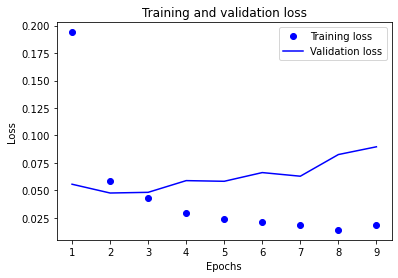

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss") # "bo" is for blue dot
plt.plot(epochs, val_loss_values, "b", label="Validation loss") # "b" is for "solid blue line."
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

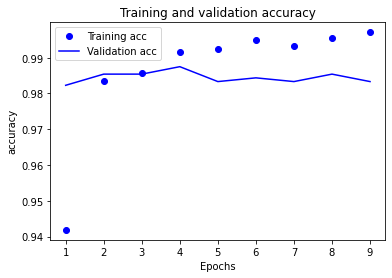

In [ ]:
plt.clf() # Clears the figure
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

The model seems to peak at the fourth epoch and degrades. To prevent overfitting, let's train a new model from scratch for four epochs and then evaluate it on the test data.

### 1.8 Retrain the model

Retraining a model from scratch

In [ ]:
model = keras.Sequential([
    text_vectorizer,
    layers.Embedding(len(text_vectorizer.get_vocabulary()), 64, mask_zero=True),
    layers.Bidirectional(keras.layers.LSTM(64,  return_sequences=True)),
    layers.Bidirectional(keras.layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer="rmsprop",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=["accuracy"])

model.fit(train_data,
          epochs=4,
          validation_steps=30,
          validation_data=test_data)


Epoch 1/4
131/131 [==============================] - 440s 3s/step - loss: 0.1772 - accuracy: 0.9466 - val_loss: 0.0595 - val_accuracy: 0.9833
Epoch 2/4
131/131 [==============================] - 403s 3s/step - loss: 0.0576 - accuracy: 0.9847 - val_loss: 0.0560 - val_accuracy: 0.9854
Epoch 3/4
131/131 [==============================] - 398s 3s/step - loss: 0.0411 - accuracy: 0.9888 - val_loss: 0.0536 - val_accuracy: 0.9854
Epoch 4/4
131/131 [==============================] - 398s 3s/step - loss: 0.0321 - accuracy: 0.9899 - val_loss: 0.0592 - val_accuracy: 0.9854


Evaluate the new model

In [ ]:
results = model.evaluate(test_data)

44/44 [==============================] - 25s 575ms/step - loss: 0.0659 - accuracy: 0.9820


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)

44/44 [==============================] - 25s 573ms/step - loss: 0.0659 - accuracy: 0.9820


The first number, 0.06, is the test loss, and the second number, 0.98, is the test accuracy.

This model achieves an accuracy of 98%.

Using a trained model to generate predictions on new data

In [ ]:
# Function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    predictions = model.predict([pred_text])
    print(predictions)
    p = predictions[0][0]
    if p > 0.5:
        return [p, "spam"]
    else:
        return [p, "ham"]

# pred_text = "how are you doing today?"
pred_text = "Amazon is sending you a $100 gift card. Please reply with your"\
"username, password, and authentication code to receive your refund."

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 267ms/step
[[7.4326015]]
[7.4326015, 'spam']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

# Function call
test_predictions()


1/1 [==============================] - 0s 276ms/step
[[-12.532708]]
1/1 [==============================] - 0s 295ms/step
[[1.489769]]
1/1 [==============================] - 0s 267ms/step
[[-10.447427]]
1/1 [==============================] - 0s 282ms/step
[[7.402082]]
1/1 [==============================] - 0s 309ms/step
[[9.648817]]
1/1 [==============================] - 0s 265ms/step
[[-11.837672]]
1/1 [==============================] - 0s 267ms/step
[[-12.045206]]
You passed the challenge. Great job!
